In [14]:
from fastai import *
from fastai.vision import *
import numpy as np
import os
# print(os.getcwd())''
path = os.getcwd() + '/dataset'
path = Path(path)
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train= 'train', test= 'test', valid_pct=0.2, num_workers=8, bs=256)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (140800 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
CPFSK,CPFSK,CPFSK,CPFSK,CPFSK
Path: /home/adeebabbas/Desktop/training_zone/dataset;

Valid: LabelList (35200 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
GFSK,CPFSK,CPFSK,QPSK,BPSK
Path: /home/adeebabbas/Desktop/training_zone/dataset;

Test: LabelList (44000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /home/adeebabbas/Desktop/training_zone/dataset

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])


In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

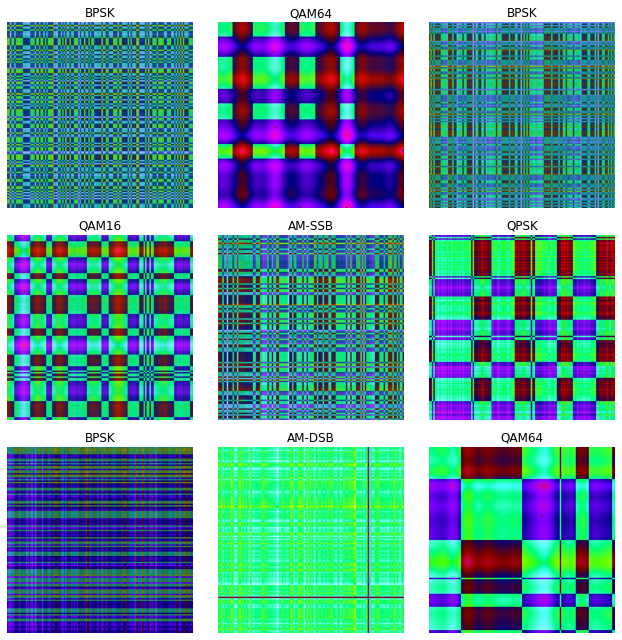

In [9]:
data.show_batch(rows=3, figsize=(9,9))

In [10]:
import torch
print(torch.cuda.get_device_name(0))
torch.cuda.is_available()

GeForce RTX 2080 Ti


True

In [15]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.704972,1.626909,0.386108,0.613892,02:29
1,1.656074,1.595494,0.402187,0.597812,02:29
2,1.620265,1.556826,0.414545,0.585455,02:29
3,1.554121,1.532996,0.421705,0.578295,02:31
4,1.558167,1.515125,0.428153,0.571847,02:29
5,1.520441,1.497556,0.432472,0.567528,02:31
6,1.503415,1.490813,0.435085,0.564915,02:31
7,1.473320,1.487771,0.440597,0.559403,02:31
8,1.480085,1.486927,0.441847,0.558153,02:30
9,1.454931,1.486886,0.441563,0.558438,02:29


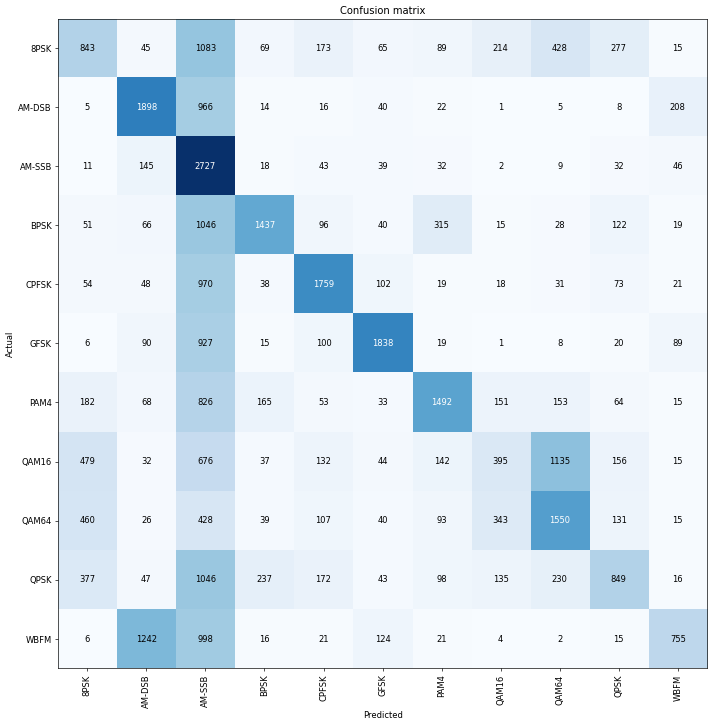

In [16]:
learn.save('stage-1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


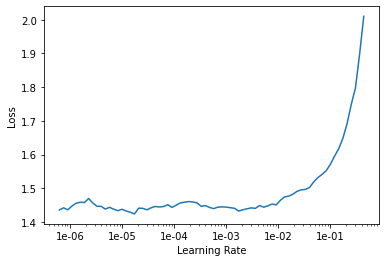

In [18]:
learn.recorder.plot()

In [23]:
learn.load('stage-1')
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.470222,1.484812,0.441051,0.558949,03:28
1,1.514424,1.483133,0.440824,0.559176,03:28
2,1.492172,1.484041,0.442330,0.557670,03:29
3,1.475247,1.446657,0.457188,0.542813,03:29
4,1.404452,1.428243,0.463608,0.536392,03:29
5,1.410425,1.398364,0.473352,0.526648,03:29
6,1.386504,1.393340,0.475511,0.524489,03:29
7,1.385283,1.376966,0.488295,0.511705,03:29
8,1.318882,1.387429,0.487273,0.512727,03:30
9,1.275454,1.394283,0.486420,0.513580,03:29


In [24]:
learn.save('stage-2')
# help(learn)

In [25]:
res18 = cnn_learner(data, models.resnet18, metrics=[accuracy, error_rate])
res18.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.115909,1.819694,0.331562,0.668437,00:50
1,1.778605,1.725917,0.362102,0.637898,00:54
2,1.698808,1.632983,0.386108,0.613892,00:56
3,1.640146,1.593359,0.396648,0.603352,00:57
4,1.604079,1.572711,0.408097,0.591903,00:58
5,1.581559,1.556405,0.414403,0.585597,00:57
6,1.554783,1.546920,0.417045,0.582955,00:59
7,1.548894,1.542523,0.419006,0.580994,00:59
8,1.523904,1.539500,0.421989,0.578011,01:00
9,1.521441,1.540113,0.421108,0.578892,00:59


In [27]:
res18.save('res18_stg1')
res18.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


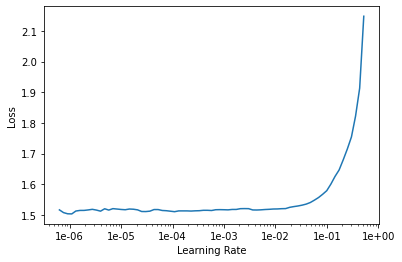

In [28]:
res18.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


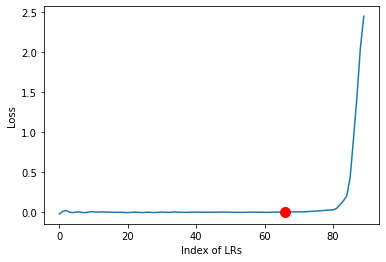

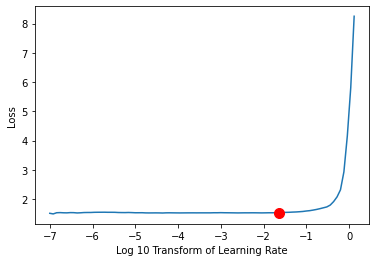

0.022908676527677745

In [30]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use
find_appropriate_lr(res18, plot = True)

In [31]:
res18.unfreeze()
res18.fit_one_cycle(30, 0.022908676527677745)
res18.save('res18_stg2')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.538295,1.563310,0.410881,0.589119,01:05
1,1.503496,1.783391,0.377273,0.622727,01:09
2,1.478048,1.612527,0.406619,0.593381,01:10
3,1.460340,1.550363,0.418438,0.581563,01:10
4,1.452752,1.450482,0.463523,0.536477,01:10
5,1.458475,1.467289,0.461335,0.538665,01:10
6,1.446308,1.494275,0.432443,0.567557,01:11
7,1.444424,1.502740,0.438977,0.561023,01:10
8,1.434668,1.508459,0.450994,0.549006,01:10
9,1.422055,1.460614,0.468097,0.531903,01:08


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


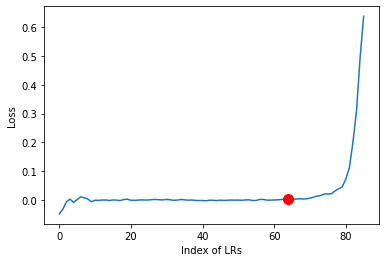

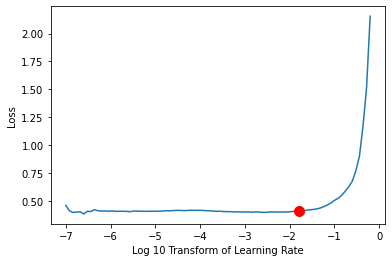

0.01584893192461114

In [32]:
find_appropriate_lr(res18, plot = True)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


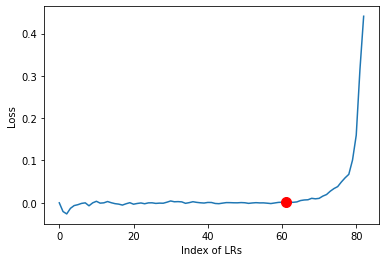

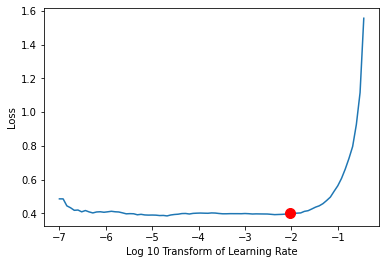

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.424010,3.535884,0.451193,0.548807,01:07
1,0.435889,3.648780,0.453210,0.546790,01:08
2,0.459134,3.558083,0.454659,0.545341,01:08
3,0.521389,2.986415,0.454688,0.545313,01:08
4,0.602946,2.567186,0.452528,0.547472,01:07
5,0.685073,2.238154,0.448580,0.551420,01:07
6,0.755144,2.136745,0.460682,0.539318,01:08
7,0.809143,2.074034,0.440937,0.559062,01:07
8,0.824726,1.940880,0.449659,0.550341,01:08
9,0.823031,1.996693,0.450341,0.549659,01:07


In [33]:
res18.load('res18_stg2')
res18.unfreeze()
res18.fit_one_cycle(30, find_appropriate_lr(res18, plot = True))
res18.save('res18_stg3')

In [37]:
learn.load('stage-2')
learn.unfreeze()
find_appropriate_lr(learn)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0.0002754228703338166

In [38]:
learn.fit_one_cycle(20, 0.0002754228703338166)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.186381,3.937212,0.436023,0.563977,03:27
1,0.225697,3.836507,0.435994,0.564006,03:36


KeyboardInterrupt: 

In [ ]:
#Both the models Resnet 50, 34 started overfitting
# The configuration was 
# encoder1= RecurrencePlot()
# encoder2= MTF()
# encoder3= GADF()